# 1. Data Exploration and Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from datetime import datetime, timedelta


df = pd.read_csv('visits.csv')

print(df.head())
print(df.info())
print(df.columns)

   countycode   county state       date  visit_bradley  counts_bradley  \
0        1069  houston    AL  1/1/2000               0               0   
1        1069  houston    AL  1/2/2000               0               0   
2        1069  houston    AL  1/3/2000               0               0   
3        1069  houston    AL  1/4/2000               0               0   
4        1069  houston    AL  1/5/2000               0               0   

   hcounts_bradley  visit_buchanan  counts_buchanan  hcounts_buchanan  ...  \
0                0               0                0                 0  ...   
1                0               0                0                 0  ...   
2                0               0                0                 0  ...   
3                0               0                0                 0  ...   
4                0               0                0                 0  ...   

   hcounts_bush  visit_cheney  counts_cheney  hcounts_cheney  visit_gore  \
0         

In [3]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# 2. Basic Analysis (without control variables)

In [4]:
# Define main party candidates (excluding Bradley and Buchanan)
main_candidates = ['Bush', 'Gore', 'Cheney', 'Lieberman']

# Basic statistics
print("=== VISIT STATISTICS ===")
for candidate in main_candidates:
    visit_col = f'visit_{candidate.lower()}'
    total_visits = df[visit_col].sum()
    counties_visited = df[df[visit_col] == 1]['countycode'].nunique()
    print(f"{candidate}: {total_visits} total visits, {counties_visited} unique counties visited")

print("\n=== COVERAGE STATISTICS ===")
for candidate in main_candidates:
    count_col = f'counts_{candidate.lower()}'
    hcount_col = f'hcounts_{candidate.lower()}'
    print(f"\n{candidate}:")
    print(f"  Full text mentions - Mean: {df[count_col].mean():.2f}, Median: {df[count_col].median():.0f}, Max: {df[count_col].max()}")
    print(f"  Headline mentions - Mean: {df[hcount_col].mean():.2f}, Median: {df[hcount_col].median():.0f}, Max: {df[hcount_col].max()}")

# Data overview
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"Number of counties: {df['countycode'].nunique()}")
print(f"Number of states: {df['state'].nunique()}")

=== VISIT STATISTICS ===
Bush: 37 total visits, 23 unique counties visited
Gore: 41 total visits, 14 unique counties visited
Cheney: 5 total visits, 5 unique counties visited
Lieberman: 5 total visits, 5 unique counties visited

=== COVERAGE STATISTICS ===

Bush:
  Full text mentions - Mean: 3.92, Median: 1, Max: 165
  Headline mentions - Mean: 0.79, Median: 0, Max: 51

Gore:
  Full text mentions - Mean: 3.25, Median: 1, Max: 168
  Headline mentions - Mean: 0.65, Median: 0, Max: 32

Cheney:
  Full text mentions - Mean: 0.45, Median: 0, Max: 28
  Headline mentions - Mean: 0.06, Median: 0, Max: 11

Lieberman:
  Full text mentions - Mean: 0.32, Median: 0, Max: 37
  Headline mentions - Mean: 0.05, Median: 0, Max: 13

Date range: 2000-01-01 00:00:00 to 2000-12-31 00:00:00
Number of counties: 91
Number of states: 22



Analyzing temporal patterns for Bush...


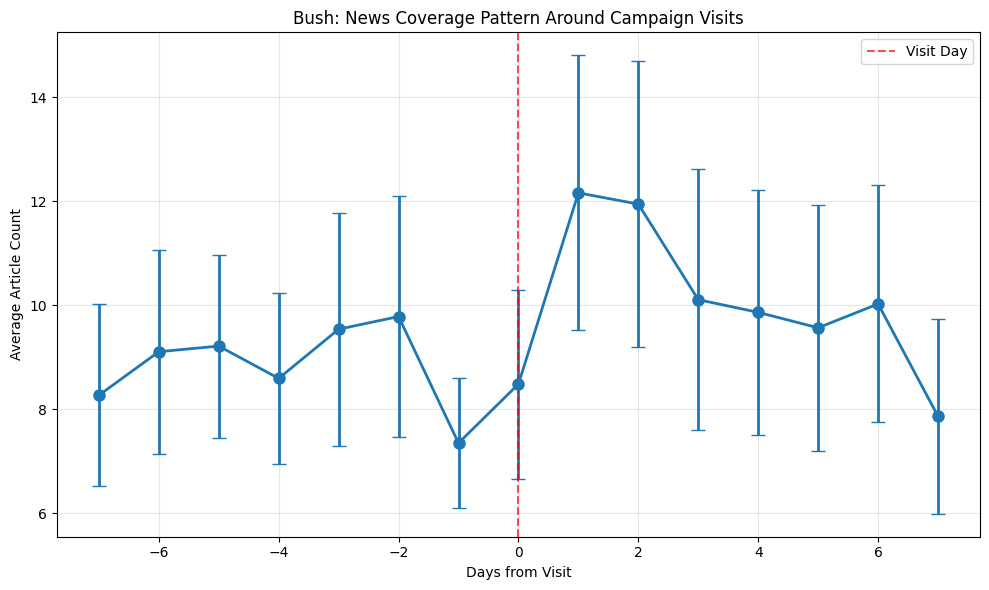


Analyzing temporal patterns for Gore...


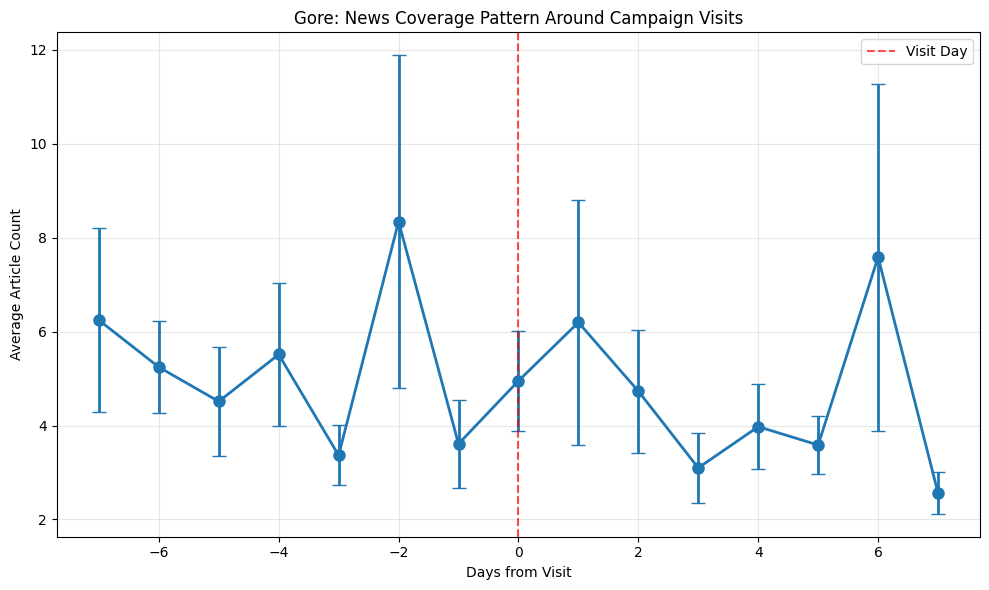


Analyzing temporal patterns for Cheney...


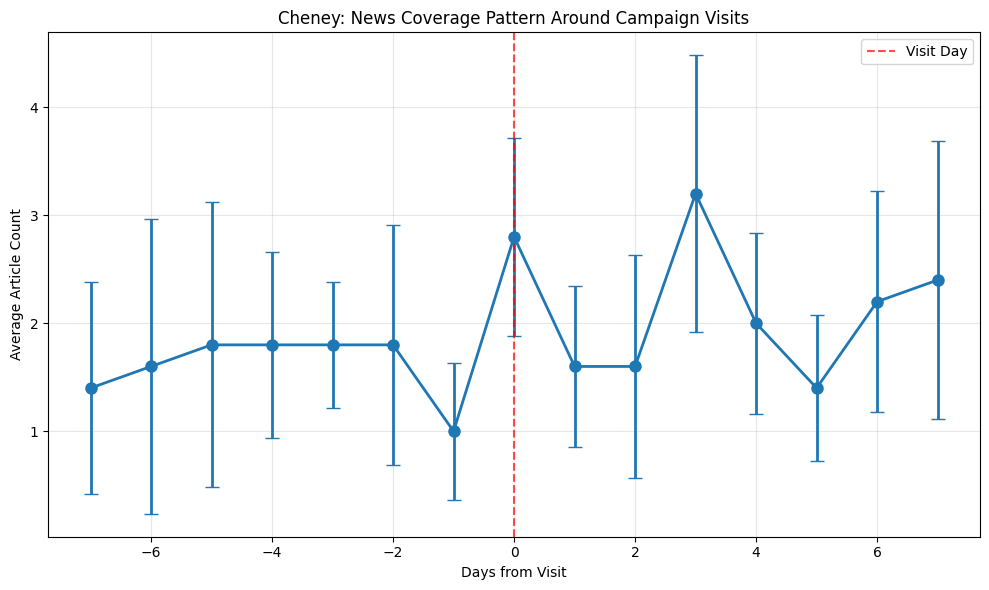


Analyzing temporal patterns for Lieberman...


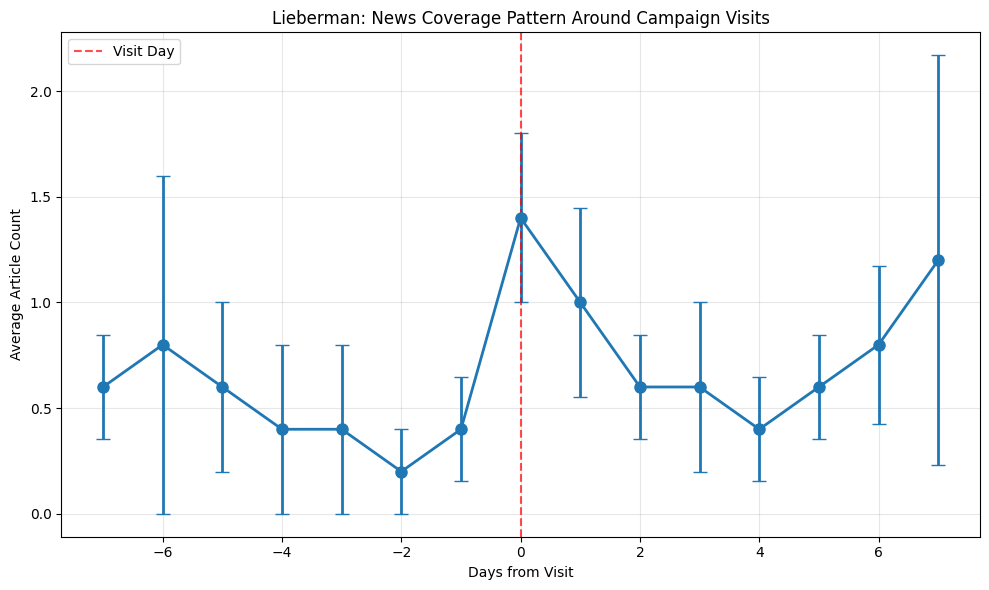

In [25]:
def analyze_temporal_pattern(df, candidate, window_days=7):
    """Analyze coverage patterns around visit dates"""
    visit_col = f'visit_{candidate.lower()}'
    count_col = f'counts_{candidate.lower()}'

    # Find all visit events
    visit_events = df[df[visit_col] == 1][['countycode', 'date']].drop_duplicates()

    temporal_data = []

    for _, visit in visit_events.iterrows():
        county = visit['countycode']
        visit_date = visit['date']

        # Get county data around visit
        county_df = df[df['countycode'] == county].copy()
        county_df['days_from_visit'] = (county_df['date'] - visit_date).dt.days

        # Filter to window
        window_df = county_df[
            (county_df['days_from_visit'] >= -window_days) &
            (county_df['days_from_visit'] <= window_days)
        ]

        if len(window_df) > 0:
            temporal_data.append(window_df[['days_from_visit', count_col]])

    if temporal_data:
        # Combine all events
        all_temporal = pd.concat(temporal_data)
        avg_by_day = all_temporal.groupby('days_from_visit')[count_col].agg(['mean', 'sem'])

        # Plot
        plt.figure(figsize=(10, 6))
        plt.errorbar(avg_by_day.index, avg_by_day['mean'],
                     yerr=avg_by_day['sem'],
                     marker='o', linewidth=2, markersize=8, capsize=5)
        plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Visit Day')
        plt.xlabel('Days from Visit')
        plt.ylabel('Average Article Count')
        plt.title(f'{candidate}: News Coverage Pattern Around Campaign Visits')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'{candidate}_temporal_pattern.png', dpi=300, bbox_inches='tight')
        plt.show()

        return avg_by_day

    return None

# Analyze temporal patterns
temporal_results = {}
for candidate in main_candidates:
    print(f"\nAnalyzing temporal patterns for {candidate}...")
    temporal_results[candidate] = analyze_temporal_pattern(df, candidate)

In [20]:
import pandas as pd

results = []
candidates = ['Bush', 'Gore', 'Cheney', 'Lieberman']

for candidate in candidates:
    visit_col = f'visit_{candidate.lower()}'
    count_col = f'counts_{candidate.lower()}'

    no_visit_mean = df[df[visit_col] == 0][count_col].mean()
    visit_mean = df[df[visit_col] == 1][count_col].mean()

    no_visit_median = df[df[visit_col] == 0][count_col].median()
    visit_median = df[df[visit_col] == 1][count_col].median()

    no_visit_n = len(df[df[visit_col] == 0])
    visit_n = len(df[df[visit_col] == 1])

    difference = visit_mean - no_visit_mean
    pct_change = (difference / no_visit_mean) * 100

    results.append({
        'Candidate': candidate,
        'No Visit Mean': f'{no_visit_mean:.2f}',
        'No Visit Median': f'{no_visit_median:.0f}',
        'No Visit N': f'{no_visit_n:,}',
        'Visit Mean': f'{visit_mean:.2f}',
        'Visit Median': f'{visit_median:.0f}',
        'Visit N': f'{visit_n}',
        'Difference': f'+{difference:.2f}',
        '% Change': f'+{pct_change:.1f}%'
    })

table_df = pd.DataFrame(results)

print("Table 2: Newspaper Coverage by Visit Status")
print("=" * 80)
print(table_df.to_string(index=False))


simple_results = []
for candidate in candidates:
    visit_col = f'visit_{candidate.lower()}'
    count_col = f'counts_{candidate.lower()}'

    no_visit_mean = df[df[visit_col] == 0][count_col].mean()
    visit_mean = df[df[visit_col] == 1][count_col].mean()
    visit_n = len(df[df[visit_col] == 1])

    difference = visit_mean - no_visit_mean
    pct_change = (difference / no_visit_mean) * 100

    simple_results.append({
        'Candidate': candidate,
        'No Visit': f'{no_visit_mean:.2f}',
        'Visit': f'{visit_mean:.2f}',
        'Difference': f'+{difference:.2f}',
        '% Change': f'+{pct_change:.1f}%',
        'N (Visit)': visit_n
    })

simple_df = pd.DataFrame(simple_results)
print("\n\nTable 2: Mean Newspaper Coverage by Visit Status (Simple Version)")
print("=" * 60)
print(simple_df.to_string(index=False))

Table 2: Newspaper Coverage by Visit Status
Candidate No Visit Mean No Visit Median No Visit N Visit Mean Visit Median Visit N Difference % Change
     Bush          3.92               1     33,269       8.49            4      37      +4.57  +116.6%
     Gore          3.24               1     33,265       4.95            3      41      +1.71   +52.7%
   Cheney          0.45               0     33,301       2.80            2       5      +2.35  +525.0%
Lieberman          0.32               0     33,301       1.40            1       5      +1.08  +342.5%


Table 2: Mean Newspaper Coverage by Visit Status (Simple Version)
Candidate No Visit Visit Difference % Change  N (Visit)
     Bush     3.92  8.49      +4.57  +116.6%         37
     Gore     3.24  4.95      +1.71   +52.7%         41
   Cheney     0.45  2.80      +2.35  +525.0%          5
Lieberman     0.32  1.40      +1.08  +342.5%          5


In [7]:
def analyze_visit_effect(df, candidate):
    """Analyze the effect of campaign visits on news coverage"""
    visit_col = f'visit_{candidate.lower()}'
    count_col = f'counts_{candidate.lower()}'
    hcount_col = f'hcounts_{candidate.lower()}'

    # Group statistics
    visit_stats = df.groupby(visit_col).agg({
        count_col: ['mean', 'median', 'std', 'count'],
        hcount_col: ['mean', 'median', 'std', 'count']
    }).round(2)

    # Calculate effect sizes
    effect_counts = visit_stats[count_col]['mean'][1] - visit_stats[count_col]['mean'][0]
    effect_hcounts = visit_stats[hcount_col]['mean'][1] - visit_stats[hcount_col]['mean'][0]

    # T-test
    visit_counts = df[df[visit_col] == 1][count_col]
    no_visit_counts = df[df[visit_col] == 0][count_col]
    t_stat, p_value = stats.ttest_ind(visit_counts, no_visit_counts)

    print(f"\n=== {candidate} VISIT EFFECT ANALYSIS ===")
    print(visit_stats)
    print(f"\nVisit Effects:")
    print(f"  Full text mentions increase: {effect_counts:.2f} ({effect_counts/visit_stats[count_col]['mean'][0]*100:.1f}%)")
    print(f"  Headline mentions increase: {effect_hcounts:.2f}")
    print(f"  T-test: t={t_stat:.3f}, p={p_value:.4f}")

    return {
        'candidate': candidate,
        'effect_counts': effect_counts,
        'effect_hcounts': effect_hcounts,
        't_stat': t_stat,
        'p_value': p_value
    }

# Analyze each candidate
results = {}
for candidate in main_candidates:
    results[candidate] = analyze_visit_effect(df, candidate)


=== Bush VISIT EFFECT ANALYSIS ===
           counts_bush                      hcounts_bush                    
                  mean median    std  count         mean median   std  count
visit_bush                                                                  
0                 3.92    1.0   8.04  33269         0.79    0.0  1.91  33269
1                 8.49    4.0  11.05     37         2.24    1.0  3.07     37

Visit Effects:
  Full text mentions increase: 4.57 (116.6%)
  Headline mentions increase: 1.45
  T-test: t=3.455, p=0.0006

=== Gore VISIT EFFECT ANALYSIS ===
           counts_gore                     hcounts_gore                    
                  mean median   std  count         mean median   std  count
visit_gore                                                                 
0                 3.24    1.0  6.96  33265         0.65    0.0  1.65  33265
1                 4.95    3.0  6.80     41         1.07    0.0  1.97     41

Visit Effects:
  Full text mentions in

# 3. Control Variable Analysis

In [27]:
print("=== VISIT PATTERNS ANALYSIS ===\n")

for candidate in main_candidates:
    visit_col = f'visit_{candidate.lower()}'
    count_col = f'counts_{candidate.lower()}'

    # Get visit details
    visits_df = df[df[visit_col] == 1][['date', 'state', 'county', count_col]]

    print(f"\n{candidate} Visit Details:")
    print(f"Number of visits: {len(visits_df)}")
    print(f"States visited: {visits_df['state'].nunique()}")
    print(f"Counties visited: {visits_df['county'].nunique()}")

    # Check if multiple visits to same county
    revisits = visits_df.groupby('county').size()
    if (revisits > 1).any():
        print(f"Counties with multiple visits: {(revisits > 1).sum()}")

    # Date range
    print(f"First visit: {visits_df['date'].min()}")
    print(f"Last visit: {visits_df['date'].max()}")

    # Top states
    print(f"Top 3 states by visits: {visits_df['state'].value_counts().head(3).to_dict()}")

print("\n=== BASELINE COVERAGE PATTERNS ===\n")

for candidate in main_candidates:
    count_col = f'counts_{candidate.lower()}'

    # Overall coverage statistics
    print(f"\n{candidate} Overall Coverage:")
    print(f"Mean: {df[count_col].mean():.2f}")
    print(f"Median: {df[count_col].median():.0f}")
    print(f"% of days with zero coverage: {(df[count_col] == 0).mean()*100:.1f}%")
    print(f"Max coverage in dataset: {df[count_col].max()}")

print("\n=== COMPETITION EFFECTS ===")

# Check if candidates visit same places
visit_overlap = pd.DataFrame()
for candidate in main_candidates:
    visit_col = f'visit_{candidate.lower()}'
    visit_counties = set(df[df[visit_col] == 1]['countycode'].unique())

    for other in main_candidates:
        if other != candidate:
            other_col = f'visit_{other.lower()}'
            other_counties = set(df[df[other_col] == 1]['countycode'].unique())
            overlap = len(visit_counties & other_counties)
            print(f"{candidate} and {other} visited {overlap} same counties")


=== VISIT PATTERNS ANALYSIS ===


Bush Visit Details:
Number of visits: 37
States visited: 8
Counties visited: 23
Counties with multiple visits: 5
First visit: 2000-02-22 00:00:00
Last visit: 2000-10-31 00:00:00
Top 3 states by visits: {'CA': 19, 'FL': 8, 'MI': 4}

Gore Visit Details:
Number of visits: 41
States visited: 8
Counties visited: 14
Counties with multiple visits: 7
First visit: 2000-02-10 00:00:00
Last visit: 2000-11-06 00:00:00
Top 3 states by visits: {'DC': 13, 'CA': 11, 'FL': 7}

Cheney Visit Details:
Number of visits: 5
States visited: 2
Counties visited: 5
First visit: 2000-08-31 00:00:00
Last visit: 2000-11-05 00:00:00
Top 3 states by visits: {'CA': 3, 'FL': 2}

Lieberman Visit Details:
Number of visits: 5
States visited: 2
Counties visited: 5
First visit: 2000-08-22 00:00:00
Last visit: 2000-11-03 00:00:00
Top 3 states by visits: {'FL': 3, 'IL': 2}

=== BASELINE COVERAGE PATTERNS ===


Bush Overall Coverage:
Mean: 3.92
Median: 1
% of days with zero coverage: 38.2%
Max

## 3.1 Check for pre-visit trends

In [10]:
print("\n=== PRE-VISIT TRENDS ANALYSIS ===")

def check_pre_trends(df, candidate, days_before=7):
    visit_col = f'visit_{candidate.lower()}'
    count_col = f'counts_{candidate.lower()}'

    # Get all visit events
    visit_events = df[df[visit_col] == 1][['countycode', 'date']]

    pre_visit_coverage = []

    for _, event in visit_events.iterrows():
        county = event['countycode']
        visit_date = event['date']

        # Get coverage in the week before visit
        county_data = df[df['countycode'] == county]
        pre_visit_data = county_data[
            (county_data['date'] >= visit_date - pd.Timedelta(days=days_before)) &
            (county_data['date'] < visit_date)
        ]

        if len(pre_visit_data) > 0:
            pre_visit_coverage.extend(pre_visit_data[count_col].values)

    if pre_visit_coverage:
        avg_pre_visit = np.mean(pre_visit_coverage)
        baseline = df[df[visit_col] == 0][count_col].mean()

        print(f"\n{candidate}:")
        print(f"Average coverage in week before visits: {avg_pre_visit:.2f}")
        print(f"Baseline coverage (no visits): {baseline:.2f}")
        print(f"Pre-visit elevation: {avg_pre_visit - baseline:.2f}")

for candidate in main_candidates:
    check_pre_trends(df, candidate)


=== PRE-VISIT TRENDS ANALYSIS ===

Bush:
Average coverage in week before visits: 8.84
Baseline coverage (no visits): 3.92
Pre-visit elevation: 4.92

Gore:
Average coverage in week before visits: 5.26
Baseline coverage (no visits): 3.24
Pre-visit elevation: 2.02

Cheney:
Average coverage in week before visits: 1.60
Baseline coverage (no visits): 0.45
Pre-visit elevation: 1.15

Lieberman:
Average coverage in week before visits: 0.49
Baseline coverage (no visits): 0.32
Pre-visit elevation: 0.17


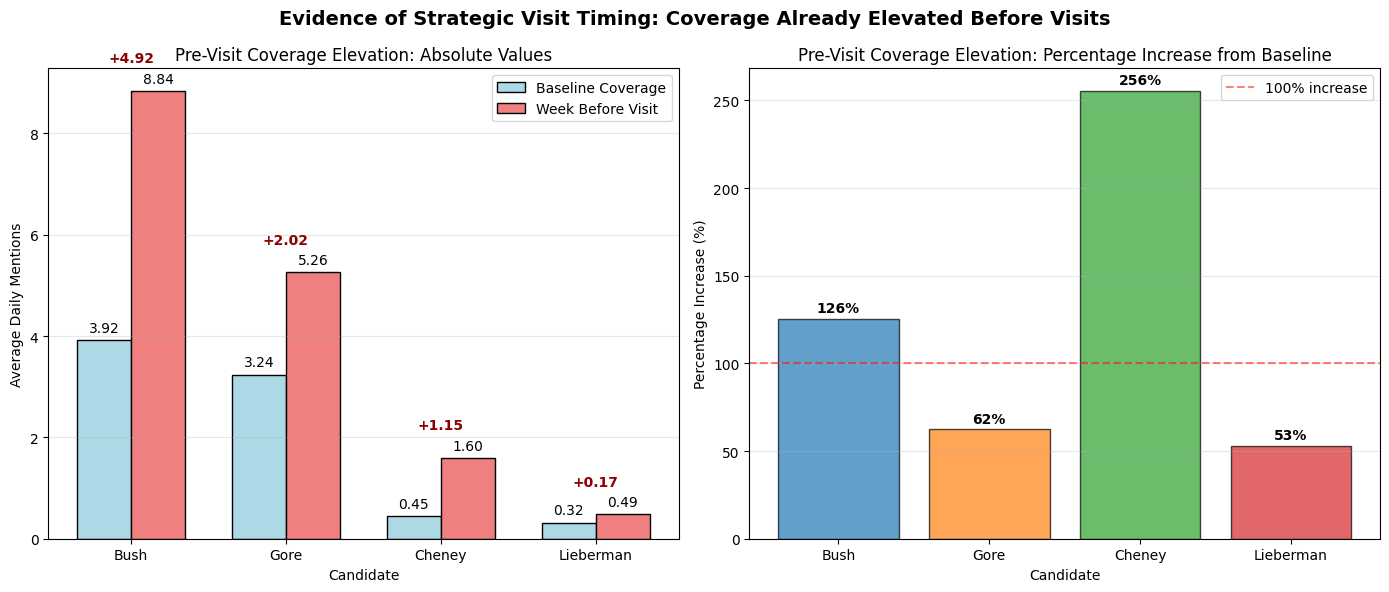

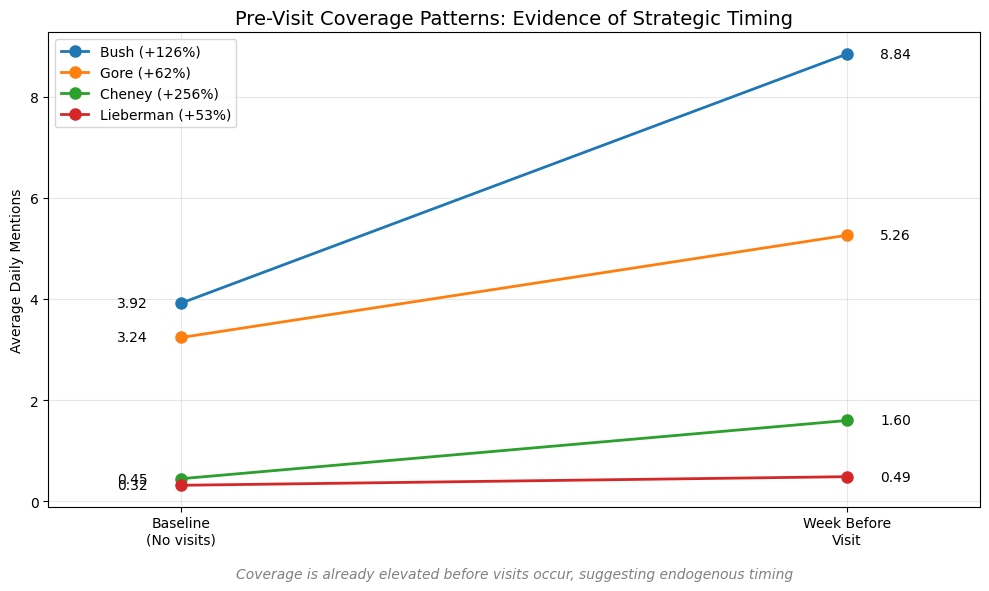

In [21]:
import matplotlib.pyplot as plt
import numpy as np

candidates = ['Bush', 'Gore', 'Cheney', 'Lieberman']
week_before = [8.84, 5.26, 1.60, 0.49]
baseline = [3.92, 3.24, 0.45, 0.32]
elevation = [4.92, 2.02, 1.15, 0.17]
pct_elevation = [(e/b)*100 for e, b in zip(elevation, baseline)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Figure 1: Absolute Value Comparison
x = np.arange(len(candidates))
width = 0.35

bars1 = ax1.bar(x - width/2, baseline, width, label='Baseline Coverage', color='lightblue', edgecolor='black')
bars2 = ax1.bar(x + width/2, week_before, width, label='Week Before Visit', color='lightcoral', edgecolor='black')

for i, (b, w) in enumerate(zip(baseline, week_before)):
    ax1.text(i - width/2, b + 0.1, f'{b:.2f}', ha='center', va='bottom')
    ax1.text(i + width/2, w + 0.1, f'{w:.2f}', ha='center', va='bottom')
    ax1.text(i, max(b, w) + 0.5, f'+{elevation[i]:.2f}', ha='center', va='bottom',
             fontweight='bold', color='darkred')

ax1.set_xlabel('Candidate')
ax1.set_ylabel('Average Daily Mentions')
ax1.set_title('Pre-Visit Coverage Elevation: Absolute Values')
ax1.set_xticks(x)
ax1.set_xticklabels(candidates)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Figure 2: Percentage Increase
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars3 = ax2.bar(candidates, pct_elevation, color=colors, edgecolor='black', alpha=0.7)

for i, (bar, pct) in enumerate(zip(bars3, pct_elevation)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{pct:.0f}%', ha='center', va='bottom', fontweight='bold')

ax2.set_xlabel('Candidate')
ax2.set_ylabel('Percentage Increase (%)')
ax2.set_title('Pre-Visit Coverage Elevation: Percentage Increase from Baseline')
ax2.grid(True, alpha=0.3, axis='y')

ax2.axhline(y=100, color='red', linestyle='--', alpha=0.5, label='100% increase')
ax2.legend()

plt.suptitle('Evidence of Strategic Visit Timing: Coverage Already Elevated Before Visits',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('pre_visit_trends.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 3
fig2, ax3 = plt.subplots(figsize=(10, 6))

for i, candidate in enumerate(candidates):
    x_points = [0, 1]  # 0 = baseline, 1 = week before visit
    y_points = [baseline[i], week_before[i]]

    ax3.plot(x_points, y_points, 'o-', linewidth=2, markersize=8,
             label=f'{candidate} (+{pct_elevation[i]:.0f}%)')

    ax3.text(-0.05, baseline[i], f'{baseline[i]:.2f}', ha='right', va='center')
    ax3.text(1.05, week_before[i], f'{week_before[i]:.2f}', ha='left', va='center')

ax3.set_xlim(-0.2, 1.2)
ax3.set_xticks([0, 1])
ax3.set_xticklabels(['Baseline\n(No visits)', 'Week Before\nVisit'])
ax3.set_ylabel('Average Daily Mentions')
ax3.set_title('Pre-Visit Coverage Patterns: Evidence of Strategic Timing', fontsize=14)
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)

ax3.text(0.5, -0.15, 'Coverage is already elevated before visits occur, suggesting endogenous timing',
         ha='center', transform=ax3.transAxes, style='italic', color='gray')

plt.tight_layout()
plt.savefig('pre_visit_trends_lines.png', dpi=300, bbox_inches='tight')
plt.show()

## 3.2 Regressions

### 3.2.1 Model 2

In [23]:
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['days_to_election'] = (pd.Timestamp('2000-11-07') - df['date']).dt.days

# Create benchmark reports (e.g. 7-day moving average)
for candidate in ['bush', 'gore', 'cheney', 'lieberman']:
    count_col = f'counts_{candidate}'
    baseline_col = f'baseline_{candidate}'
    df[baseline_col] = df.groupby('countycode')[count_col].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean().shift(1)
    )

In [24]:
print("\n=== REGRESSION WITH CONTROLS ===")

import statsmodels.formula.api as smf

# Prepare data for regression
reg_df = df.copy()

# Create time variables
reg_df['month'] = reg_df['date'].dt.month
reg_df['day_of_week'] = reg_df['date'].dt.dayofweek
reg_df['days_to_election'] = (pd.Timestamp('2000-11-07') - reg_df['date']).dt.days

# Create baseline coverage variables (first month average by county)
jan_data = reg_df[reg_df['month'] == 1]
for candidate in main_candidates:
    count_col = f'counts_{candidate.lower()}'
    baseline = jan_data.groupby('countycode')[count_col].mean()
    reg_df[f'baseline_{candidate.lower()}'] = reg_df['countycode'].map(baseline)

# Run regressions with controls
for candidate in main_candidates:
    visit_col = f'visit_{candidate.lower()}'
    count_col = f'counts_{candidate.lower()}'
    baseline_col = f'baseline_{candidate.lower()}'

    # Create formula
    formula = f"{count_col} ~ {visit_col} + {baseline_col} + C(month) + C(day_of_week) + days_to_election + C(countycode)"

    try:
        model = smf.ols(formula, data=reg_df).fit()

        print(f"\n{candidate} Regression with Controls:")
        print(f"Visit coefficient: {model.params[visit_col]:.3f}")
        print(f"P-value: {model.pvalues[visit_col]:.4f}")
        print(f"R-squared: {model.rsquared:.3f}")
    except:
        print(f"\n{candidate}: Regression failed (likely due to multicollinearity)")


=== REGRESSION WITH CONTROLS ===

Bush Regression with Controls:
Visit coefficient: -1.105
P-value: 0.2652
R-squared: 0.444

Gore Regression with Controls:
Visit coefficient: -0.325
P-value: 0.6958
R-squared: 0.428

Cheney Regression with Controls:
Visit coefficient: 1.101
P-value: 0.0378
R-squared: 0.280

Lieberman Regression with Controls:
Visit coefficient: 0.679
P-value: 0.1507
R-squared: 0.262


### 3.2.2 Model 3 - Panel Regression

In [13]:
def run_panel_regression(df, candidate):
    """Run panel regression with county fixed effects"""
    visit_col = f'visit_{candidate.lower()}'
    count_col = f'counts_{candidate.lower()}'

    # Prepare regression data
    reg_df = df[[visit_col, count_col, 'countycode', 'date']].copy()

    # County fixed effects (within transformation)
    reg_df['count_demean'] = reg_df.groupby('countycode')[count_col].transform(
        lambda x: x - x.mean()
    )
    reg_df['visit_demean'] = reg_df.groupby('countycode')[visit_col].transform(
        lambda x: x - x.mean()
    )

    # Add time trend
    reg_df['time_trend'] = (reg_df['date'] - reg_df['date'].min()).dt.days
    reg_df['time_trend_demean'] = reg_df.groupby('countycode')['time_trend'].transform(
        lambda x: x - x.mean()
    )

    # Run regression
    X = reg_df[['visit_demean', 'time_trend_demean']]
    X = sm.add_constant(X)
    y = reg_df['count_demean']

    model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': reg_df['countycode']})

    print(f"\n=== {candidate} FIXED EFFECTS REGRESSION ===")
    print(model.summary())

    return model

# Run regressions
regression_models = {}
for candidate in main_candidates:
    regression_models[candidate] = run_panel_regression(df, candidate)


=== Bush FIXED EFFECTS REGRESSION ===
                            OLS Regression Results                            
Dep. Variable:           count_demean   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     24.62
Date:                Fri, 15 Aug 2025   Prob (F-statistic):           2.97e-09
Time:                        22:02:02   Log-Likelihood:            -1.0766e+05
No. Observations:               33306   AIC:                         2.153e+05
Df Residuals:                   33303   BIC:                         2.153e+05
Df Model:                           2                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

## 3.3 Create comparison table

In [14]:

print("\n=== CREATING REGRESSION COMPARISON TABLE ===")

method1_results = {}

for candidate in main_candidates:
    visit_col = f'visit_{candidate.lower()}'
    count_col = f'counts_{candidate.lower()}'
    baseline_col = f'baseline_{candidate.lower()}'

    # Create formula
    formula = f"{count_col} ~ {visit_col} + {baseline_col} + C(month) + C(day_of_week) + days_to_election + C(countycode)"

    try:
        model = smf.ols(formula, data=reg_df).fit()
        method1_results[candidate] = {
            'coef': model.params[visit_col],
            'pval': model.pvalues[visit_col],
            'rsq': model.rsquared
        }
    except:
        manual_values = {
            'Bush': {'coef': -1.105, 'pval': 0.2652, 'rsq': 0.444},
            'Gore': {'coef': -0.325, 'pval': 0.6958, 'rsq': 0.428},
            'Cheney': {'coef': 1.101, 'pval': 0.0378, 'rsq': 0.280},
            'Lieberman': {'coef': 0.679, 'pval': 0.1507, 'rsq': 0.262}
        }
        method1_results[candidate] = manual_values.get(candidate, {'coef': np.nan, 'pval': np.nan, 'rsq': np.nan})

# Now create the comparison table
comparison_data = []

for candidate in main_candidates:
    # Get simple comparison results (from earlier analysis)
    simple_effect = results[candidate]['effect_counts']
    simple_pval = results[candidate]['p_value']

    # Get Method 1 results (with full controls)
    m1_coef = method1_results[candidate]['coef']
    m1_pval = method1_results[candidate]['pval']

    # Get Method 2 results (panel regression)
    m2_coef = regression_models[candidate].params['visit_demean']
    m2_pval = regression_models[candidate].pvalues['visit_demean']

    # Format coefficients with significance stars
    def format_coef(coef, pval):
        if pd.isna(coef):
            return "N/A"
        stars = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.1 else ''
        return f"{coef:.3f}{stars}"

    comparison_data.append({
        'Candidate': candidate,
        '(1) Simple Diff': format_coef(simple_effect, simple_pval),
        '(2) Full Controls': format_coef(m1_coef, m1_pval),
        '(3) Panel FE': format_coef(m2_coef, m2_pval)
    })

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Print the table
print("\nTable 1: Regression Results - Visit Effects on Newspaper Coverage")
print("="*65)
print(comparison_df.to_string(index=False))
print("\nNotes: *** p<0.01, ** p<0.05, * p<0.1")
print("(1) Simple difference in means (t-test)")
print("(2) OLS with county FE, baseline coverage, month FE, day-of-week FE, days to election")
print("(3) Panel regression with within transformation and linear time trend")


=== CREATING REGRESSION COMPARISON TABLE ===

Table 1: Regression Results - Visit Effects on Newspaper Coverage
Candidate (1) Simple Diff (2) Full Controls (3) Panel FE
     Bush        4.570***            -1.105       -1.330
     Gore           1.710            -0.325       -0.810
   Cheney        2.350***           1.101**     1.234***
Lieberman         1.080**             0.679      0.937**

Notes: *** p<0.01, ** p<0.05, * p<0.1
(1) Simple difference in means (t-test)
(2) OLS with county FE, baseline coverage, month FE, day-of-week FE, days to election
(3) Panel regression with within transformation and linear time trend


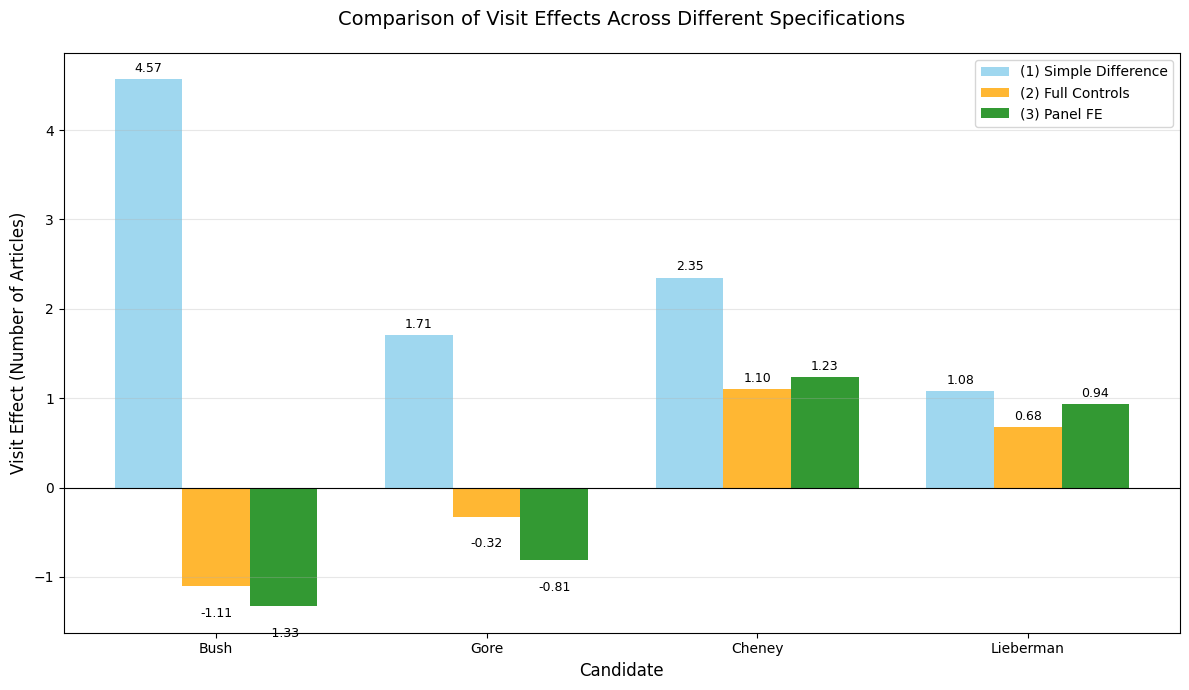

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 7))

# Data for plotting
candidates = main_candidates
x = np.arange(len(candidates))
width = 0.25

# Extract coefficients for plotting
simple_coefs = [results[c]['effect_counts'] for c in candidates]
method1_coefs = [method1_results[c]['coef'] for c in candidates]
method2_coefs = [regression_models[c].params['visit_demean'] for c in candidates]

# Create bars
bars1 = ax.bar(x - width, simple_coefs, width, label='(1) Simple Difference', color='skyblue', alpha=0.8)
bars2 = ax.bar(x, method1_coefs, width, label='(2) Full Controls', color='orange', alpha=0.8)
bars3 = ax.bar(x + width, method2_coefs, width, label='(3) Panel FE', color='green', alpha=0.8)

# Add horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Customize plot
ax.set_xlabel('Candidate', fontsize=12)
ax.set_ylabel('Visit Effect (Number of Articles)', fontsize=12)
ax.set_title('Comparison of Visit Effects Across Different Specifications', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(candidates)
ax.legend(loc='upper right')
ax.grid(True, axis='y', alpha=0.3)

# Add value labels on bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3 if height > 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom' if height > 0 else 'top',
                    fontsize=9)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

plt.tight_layout()
plt.savefig('regression_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# 4. Robustness Checks

In [16]:
def robustness_checks(df, candidate):
    """Perform various robustness checks"""
    visit_col = f'visit_{candidate.lower()}'
    count_col = f'counts_{candidate.lower()}'
    hcount_col = f'hcounts_{candidate.lower()}'

    print(f"\n=== ROBUSTNESS CHECKS FOR {candidate} ===")

    # 1. Check for outliers
    visit_coverage = df[df[visit_col] == 1][count_col]
    Q1 = visit_coverage.quantile(0.25)
    Q3 = visit_coverage.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((visit_coverage < (Q1 - 1.5 * IQR)) | (visit_coverage > (Q3 + 1.5 * IQR))).sum()
    print(f"Number of outliers in visit coverage: {outliers}")

    # 2. Weekend vs Weekday effects
    df['weekday'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['weekday'].isin([5, 6])

    weekend_effect = df[df['is_weekend'] & (df[visit_col] == 1)][count_col].mean()
    weekday_effect = df[~df['is_weekend'] & (df[visit_col] == 1)][count_col].mean()
    print(f"Weekend visit effect: {weekend_effect:.2f}")
    print(f"Weekday visit effect: {weekday_effect:.2f}")

    # 3. State-level heterogeneity
    state_effects = df[df[visit_col] == 1].groupby('state')[count_col].mean().sort_values(ascending=False)
    print(f"\nTop 5 states by visit effect:")
    print(state_effects.head())

    return {
        'outliers': outliers,
        'weekend_effect': weekend_effect,
        'weekday_effect': weekday_effect,
        'state_effects': state_effects
    }

# Run robustness checks
for candidate in main_candidates:
    robustness_checks(df, candidate)


=== ROBUSTNESS CHECKS FOR Bush ===
Number of outliers in visit coverage: 4
Weekend visit effect: 4.00
Weekday visit effect: 9.03

Top 5 states by visit effect:
state
CA    12.526316
KY     8.000000
AR     6.000000
FL     5.500000
IL     3.500000
Name: counts_bush, dtype: float64

=== ROBUSTNESS CHECKS FOR Gore ===
Number of outliers in visit coverage: 2
Weekend visit effect: 2.50
Weekday visit effect: 5.55

Top 5 states by visit effect:
state
CA    11.363636
KY     4.000000
FL     3.428571
IL     3.000000
DC     2.153846
Name: counts_gore, dtype: float64

=== ROBUSTNESS CHECKS FOR Cheney ===
Number of outliers in visit coverage: 0
Weekend visit effect: 3.00
Weekday visit effect: 2.67

Top 5 states by visit effect:
state
CA    3.666667
FL    1.500000
Name: counts_cheney, dtype: float64

=== ROBUSTNESS CHECKS FOR Lieberman ===
Number of outliers in visit coverage: 1
Weekend visit effect: 1.00
Weekday visit effect: 1.50

Top 5 states by visit effect:
state
FL    1.666667
IL    1.000000
N

# 5.Mechanism Analysis


MECHANISM ANALYSIS: Understanding Why Visits Affect Coverage

1. COMPETITION AND SPILLOVER EFFECTS
--------------------------------------------------
Question: Does a visit by one candidate affect coverage of other candidates?
This tests whether visits create a general 'campaign news' environment

Bush visits → Gore coverage: +4.030 (+124.3%)
    Statistically significant (p=0.0004)
Bush visits → Cheney coverage: +0.471 (+105.2%)
    Statistically significant (p=0.0395)
Bush visits → Lieberman coverage: +0.495 (+156.6%)
    Statistically significant (p=0.0141)
Gore visits → Bush coverage: +3.032 (+77.4%)
    Statistically significant (p=0.0158)
Gore visits → Cheney coverage: +0.088 (+19.7%)
Gore visits → Lieberman coverage: -0.122 (-38.4%)
Cheney visits → Bush coverage: +5.278 (+134.6%)
Cheney visits → Gore coverage: +5.556 (+171.2%)
Cheney visits → Lieberman coverage: +1.684 (+532.3%)
    Statistically significant (p=0.0021)
Lieberman visits → Bush coverage: -0.723 (-18.4%)
Lieberman

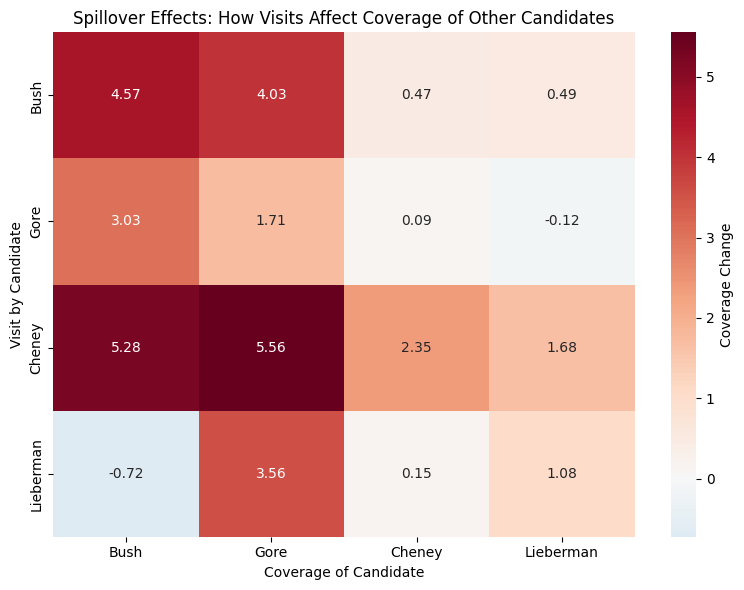



2. CUMULATIVE EFFECTS AND DIMINISHING RETURNS
--------------------------------------------------
Question: Do repeated visits have the same effect as first visits?
This tests for novelty effects and media fatigue


Bush:
  Visit #1: 4.78 articles (n=23)
  Visit #2: 4.00 articles (n=5)
  Visit #3: 7.67 articles (n=3)
  → Diminishing returns: 9.79 (204.7%) for repeat visits

Gore:
  Visit #1: 2.93 articles (n=14)
  Visit #2: 4.00 articles (n=7)
  Visit #3: 4.25 articles (n=4)
  → Diminishing returns: 3.07 (104.9%) for repeat visits

Cheney:
  Visit #1: 2.80 articles (n=5)

Lieberman:
  Visit #1: 1.40 articles (n=5)


3. NEWS CYCLE AND TIMING EFFECTS
--------------------------------------------------
Question: How long does the coverage boost last?
This examines the persistence of visit effects

Average coverage by days from visit:
  Day -3: 5.70 (lift: -0.64)
  Day -2: 8.11 (lift: +1.77)
  Day -1: 4.85 (lift: -1.49)
  Day +0: 6.11 (lift: -0.23)
  Day +1: 8.15 (lift: +1.81)
  Day +2: 7.

In [17]:
def analyze_mechanisms_detailed(df):
    """
    Explore potential mechanisms driving the visit-coverage relationship
    This helps us understand WHY visits might increase newspaper coverage
    """

    print("\n" + "="*70)
    print("MECHANISM ANALYSIS: Understanding Why Visits Affect Coverage")
    print("="*70)

    # -----------------------------
    # 1. COMPETITION/SPILLOVER EFFECTS
    # -----------------------------
    print("\n1. COMPETITION AND SPILLOVER EFFECTS")
    print("-" * 50)
    print("Question: Does a visit by one candidate affect coverage of other candidates?")
    print("This tests whether visits create a general 'campaign news' environment\n")

    # Create a matrix to store spillover effects
    spillover_matrix = pd.DataFrame(index=main_candidates, columns=main_candidates)

    for candidate1 in main_candidates:
        for candidate2 in main_candidates:
            visit1_col = f'visit_{candidate1.lower()}'
            count2_col = f'counts_{candidate2.lower()}'

            # Calculate spillover effect
            with_visit = df[df[visit1_col] == 1][count2_col].mean()
            without_visit = df[df[visit1_col] == 0][count2_col].mean()
            effect = with_visit - without_visit

            spillover_matrix.loc[candidate1, candidate2] = effect

            if candidate1 != candidate2:
                # Calculate percentage change
                pct_change = (effect / without_visit * 100) if without_visit > 0 else 0
                print(f"{candidate1} visits → {candidate2} coverage: {effect:+.3f} ({pct_change:+.1f}%)")

                # Test significance
                t_stat, p_val = stats.ttest_ind(
                    df[df[visit1_col] == 1][count2_col],
                    df[df[visit1_col] == 0][count2_col]
                )
                if p_val < 0.05:
                    print(f"    Statistically significant (p={p_val:.4f})")

    # Visualize spillover matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(spillover_matrix.astype(float), annot=True, fmt='.2f',
                cmap='RdBu_r', center=0, cbar_kws={'label': 'Coverage Change'})
    plt.title('Spillover Effects: How Visits Affect Coverage of Other Candidates')
    plt.xlabel('Coverage of Candidate')
    plt.ylabel('Visit by Candidate')
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # 2. CUMULATIVE/DIMINISHING RETURNS
    # -----------------------------
    print("\n\n2. CUMULATIVE EFFECTS AND DIMINISHING RETURNS")
    print("-" * 50)
    print("Question: Do repeated visits have the same effect as first visits?")
    print("This tests for novelty effects and media fatigue\n")

    for candidate in main_candidates:
        visit_col = f'visit_{candidate.lower()}'
        count_col = f'counts_{candidate.lower()}'

        # Create cumulative visit counter by county
        df_sorted = df.sort_values(['countycode', 'date'])
        df_sorted['visit_number'] = df_sorted.groupby('countycode')[visit_col].cumsum()

        # Only look at actual visits
        visits_only = df_sorted[df_sorted[visit_col] == 1]

        if len(visits_only) > 0:
            print(f"\n{candidate}:")

            # Group by visit number
            visit_effects = visits_only.groupby('visit_number')[count_col].agg(['mean', 'count'])

            # Show up to 3rd visit (if exists)
            for visit_num in range(1, min(4, int(visit_effects.index.max()) + 1)):
                if visit_num in visit_effects.index:
                    mean_coverage = visit_effects.loc[visit_num, 'mean']
                    count = visit_effects.loc[visit_num, 'count']
                    print(f"  Visit #{visit_num}: {mean_coverage:.2f} articles (n={count})")

            # Test for diminishing returns
            if len(visit_effects) >= 2:
                first_visit_mean = visit_effects.loc[1, 'mean']
                later_visits = visits_only[visits_only['visit_number'] > 1][count_col]
                if len(later_visits) > 0:
                    later_mean = later_visits.mean()
                    change = later_mean - first_visit_mean
                    pct_change = (change / first_visit_mean * 100)
                    print(f"  → Diminishing returns: {change:.2f} ({pct_change:.1f}%) for repeat visits")

    # -----------------------------
    # 3. TIMING AND NEWS CYCLES
    # -----------------------------
    print("\n\n3. NEWS CYCLE AND TIMING EFFECTS")
    print("-" * 50)
    print("Question: How long does the coverage boost last?")
    print("This examines the persistence of visit effects\n")

    # Aggregate temporal effects across all candidates
    all_temporal_effects = {day: [] for day in range(-7, 8)}

    for candidate in main_candidates:
        visit_col = f'visit_{candidate.lower()}'
        count_col = f'counts_{candidate.lower()}'

        # Get all visit events
        visit_events = df[df[visit_col] == 1][['countycode', 'date']]

        for _, visit in visit_events.iterrows():
            county = visit['countycode']
            visit_date = visit['date']

            # Get county data around visit
            county_data = df[df['countycode'] == county].copy()
            county_data['days_from_visit'] = (county_data['date'] - visit_date).dt.days

            # Collect coverage for each day relative to visit
            for day in range(-7, 8):
                day_data = county_data[county_data['days_from_visit'] == day]
                if len(day_data) > 0:
                    all_temporal_effects[day].append(day_data[count_col].values[0])

    # Calculate average effects and decay rate
    print("Average coverage by days from visit:")
    baseline = np.mean(all_temporal_effects[-7] + all_temporal_effects[-6] + all_temporal_effects[-5])
    peak = np.mean(all_temporal_effects[0])

    for day in range(-3, 4):
        if all_temporal_effects[day]:
            avg = np.mean(all_temporal_effects[day])
            lift = avg - baseline
            print(f"  Day {day:+2d}: {avg:.2f} (lift: {lift:+.2f})")

    # Calculate half-life of effect
    for day in range(1, 8):
        if all_temporal_effects[day]:
            avg = np.mean(all_temporal_effects[day])
            if avg <= baseline + (peak - baseline) / 2:
                print(f"\n→ Half-life of visit effect: ~{day} days")
                break

    # -----------------------------
    # 4. STRATEGIC TIMING
    # -----------------------------
    print("\n\n4. STRATEGIC TIMING ANALYSIS")
    print("-" * 50)
    print("Question: Do candidates time visits strategically?")

    # Check if visits cluster around certain events
    df['days_to_election'] = (pd.Timestamp('2000-11-07') - df['date']).dt.days

    for candidate in main_candidates[:2]:  # Just Bush and Gore
        visit_col = f'visit_{candidate.lower()}'
        visit_days = df[df[visit_col] == 1]['days_to_election']

        if len(visit_days) > 0:
            print(f"\n{candidate} visit timing:")
            print(f"  Earliest: {visit_days.max()} days before election")
            print(f"  Latest: {visit_days.min()} days before election")
            print(f"  Median: {visit_days.median():.0f} days before election")

            # Check for clustering
            last_month = visit_days[visit_days <= 30].count()
            total = len(visit_days)
            pct_last_month = (last_month / total * 100)
            print(f"  Visits in final month: {last_month}/{total} ({pct_last_month:.1f}%)")

    # -----------------------------
    # 5. COMPLEMENTARITY WITH OTHER MEDIA
    # -----------------------------
    print("\n\n5. HEADLINE VS. FULL TEXT COVERAGE")
    print("-" * 50)
    print("Question: Do visits affect headline mentions differently?")
    print("This tests for different types of coverage\n")

    for candidate in main_candidates:
        visit_col = f'visit_{candidate.lower()}'
        count_col = f'counts_{candidate.lower()}'
        hcount_col = f'hcounts_{candidate.lower()}'

        # Compare effects on headlines vs full text
        visit_data = df[df[visit_col] == 1]
        no_visit_data = df[df[visit_col] == 0]

        # Full text effect
        full_effect = visit_data[count_col].mean() - no_visit_data[count_col].mean()
        full_pct = (full_effect / no_visit_data[count_col].mean() * 100)

        # Headline effect
        headline_effect = visit_data[hcount_col].mean() - no_visit_data[hcount_col].mean()
        if no_visit_data[hcount_col].mean() > 0:
            headline_pct = (headline_effect / no_visit_data[hcount_col].mean() * 100)
        else:
            headline_pct = float('inf') if headline_effect > 0 else 0

        print(f"{candidate}:")
        print(f"  Full text effect: +{full_effect:.2f} ({full_pct:.1f}%)")
        print(f"  Headline effect: +{headline_effect:.2f} ({headline_pct:.1f}%)")

        # Ratio of headline to full text
        if full_effect > 0:
            ratio = headline_effect / full_effect
            print(f"  Headline/Full text ratio: {ratio:.2f}")

# Run the detailed mechanism analysis
analyze_mechanisms_detailed(df)

# 6. Heterogeneity Analysis

In [28]:
# Fixed version of heterogeneity analysis
def analyze_heterogeneity_fixed(df):
    """
    Fixed version that handles low baseline coverage for VP candidates
    """

    print("\n" + "="*70)
    print("HETEROGENEITY ANALYSIS: When and Where Do Visits Matter Most?")
    print("="*70)

    # -----------------------------
    # EFFECTS BY BASELINE COVERAGE (FIXED)
    # -----------------------------
    print("\n1. HETEROGENEITY BY BASELINE MEDIA COVERAGE")
    print("-" * 50)

    # Calculate baseline coverage for each county (using January data)
    jan_data = df[df['date'].dt.month == 1]

    # Store results for visualization
    heterogeneity_results = {}

    for candidate in main_candidates:
        count_col = f'counts_{candidate.lower()}'
        visit_col = f'visit_{candidate.lower()}'

        # Calculate county baseline coverage
        baseline_coverage = jan_data.groupby('countycode')[count_col].mean()

        # For VP candidates with low coverage, use different approach
        if candidate in ['Cheney', 'Lieberman']:
            # Use binary split instead of quartiles
            median_coverage = baseline_coverage.median()
            df['baseline_group'] = df['countycode'].map(
                lambda x: 'High' if baseline_coverage.get(x, 0) > median_coverage else 'Low'
            )

            print(f"\n{candidate} - Effects by Baseline Coverage (Binary Split):")

            for group in ['Low', 'High']:
                group_data = df[df['baseline_group'] == group]

                if group_data[visit_col].sum() > 0:
                    visit_mean = group_data[group_data[visit_col] == 1][count_col].mean()
                    no_visit_mean = group_data[group_data[visit_col] == 0][count_col].mean()
                    effect = visit_mean - no_visit_mean
                    pct_effect = (effect / no_visit_mean * 100) if no_visit_mean > 0 else float('inf')
                    n_visits = group_data[visit_col].sum()

                    print(f"  {group} baseline: +{effect:.2f} articles ({pct_effect:+.1f}%) | {n_visits} visits")

        else:
            # Use quartiles for presidential candidates
            try:
                quartiles = pd.qcut(baseline_coverage, q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
                df['baseline_quartile'] = df['countycode'].map(quartiles)

                print(f"\n{candidate} - Effects by Baseline Coverage Quartile:")

                for q in ['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)']:
                    q_data = df[df['baseline_quartile'] == q]

                    if q_data[visit_col].sum() > 0:
                        visit_mean = q_data[q_data[visit_col] == 1][count_col].mean()
                        no_visit_mean = q_data[q_data[visit_col] == 0][count_col].mean()
                        effect = visit_mean - no_visit_mean
                        pct_effect = (effect / no_visit_mean * 100) if no_visit_mean > 0 else 0
                        n_visits = q_data[visit_col].sum()

                        print(f"  {q}: +{effect:.2f} articles ({pct_effect:+.1f}%) | {n_visits} visits")
            except:
                print(f"  Could not create quartiles for {candidate}")

# Run the fixed version
analyze_heterogeneity_fixed(df)


HETEROGENEITY ANALYSIS: When and Where Do Visits Matter Most?

1. HETEROGENEITY BY BASELINE MEDIA COVERAGE
--------------------------------------------------

Bush - Effects by Baseline Coverage Quartile:
  Q1 (Low): +0.43 articles (+75.1%) | 5 visits
  Q2: +0.58 articles (+36.9%) | 6 visits
  Q3: +-0.39 articles (-12.3%) | 9 visits
  Q4 (High): +5.61 articles (+54.4%) | 17 visits

Gore - Effects by Baseline Coverage Quartile:
  Q1 (Low): +0.60 articles (+150.6%) | 2 visits
  Q2: +0.76 articles (+55.0%) | 13 visits
  Q3: +0.40 articles (+14.6%) | 12 visits
  Q4 (High): +1.20 articles (+14.2%) | 14 visits

Cheney - Effects by Baseline Coverage (Binary Split):
  Low baseline: +1.17 articles (+348.8%) | 2 visits
  High baseline: +2.92 articles (+389.8%) | 3 visits

Lieberman - Effects by Baseline Coverage (Binary Split):
  Low baseline: +1.48 articles (+796.8%) | 3 visits
  High baseline: +0.19 articles (+23.3%) | 2 visits
